# Predicting Stellar Classification
using KNN, SVM, and Logistic Regression Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data
Reading in the data and basic analysis. We will be using the Stellar Classification dataset from Kaggle, found <a href="https://www.kaggle.com/vinesmsuic/star-categorization-giants-and-dwarfs">here</a>

In [2]:
stars = pd.read_csv('Star3642_balanced.csv')

In [3]:
stars.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,5.99,13.73,0.58,1.318,K5III,16.678352,0
1,8.70,2.31,1.29,-0.045,B1II,15.518060,0
2,5.77,5.50,1.03,0.855,G5III,14.471813,0
3,6.72,5.26,0.74,-0.015,B7V,15.324928,1
4,8.76,13.44,1.16,0.584,G0V,19.401997,1


#### A quick description of the column names

Vmag - Visual Apparent Magnitude, this is essentially how bright the star looks from Earth

Plx - Parallax, a measurement that indicates the distance between the Earth and the star

e_Plx - the standard error of Plx

B-V - B(lue) - V(isual) color index, this is a measurement of how much blue light is being emitted by the star. This will indicate temperature - A hot star will have a B-V value of near-0 or negative, while a cooler star will have a value closer to 2.0

SpType - Spectral Type, this indicates several things, including temperature and luminosity class. This will be talked about further below

Amag - Absolute Magnitude, how bright the star would be if viewed from a distance of 10 parsecs

TargetClass - Luminosity Class (simplified), 0 means that the star is a dwarf star, 1 means that it is a giant star.

In [4]:
stars.describe()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass
count,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000,3642.000000
mean,8.120530,7.606153,1.176568,0.827077,16.427388,0.500000
std,1.338875,11.924052,0.919999,0.436699,2.428144,0.500069
min,0.450000,-6.820000,0.470000,-0.196000,2.820000,0.000000
25%,7.370000,2.740000,0.840000,0.487250,15.150312,0.000000
50%,8.390000,4.950000,1.040000,0.867000,16.392485,0.500000
75%,9.060000,8.670000,1.270000,1.136000,18.029836,1.000000
max,12.490000,280.270000,30.290000,2.530000,29.249165,1.000000


In [5]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vmag         3642 non-null   float64
 1   Plx          3642 non-null   float64
 2   e_Plx        3642 non-null   float64
 3   B-V          3642 non-null   float64
 4   SpType       3642 non-null   object 
 5   Amag         3642 non-null   float64
 6   TargetClass  3642 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 199.3+ KB


In [6]:
stars.isnull().sum()

Vmag           0
Plx            0
e_Plx          0
B-V            0
SpType         0
Amag           0
TargetClass    0
dtype: int64

In [7]:
stars['TargetClass'].value_counts()

1    1821
0    1821
Name: TargetClass, dtype: int64

The dataset seems to already be free of nulls and the target class is perfectly balanced

## Getting rid of unneeded data
The column SpClass, or Spectral class, tells us two bits of information. The first is temperature, indcated by a letter (O, B, A, F, G, K, M), combinded with a number (0 through 9). The second is the luminosity class, indicated by the roman numerals (I, II, and III are giant stars, while IV, V and VI are dwarfs). The problem is that both of these are redundant and likely to overfit our model. Temperature is already associated with a B-V color index, and spectral type is our target class. So we will drop this column. 

In [8]:
stars.drop('SpType', axis=1, inplace=True)

## Visualizations

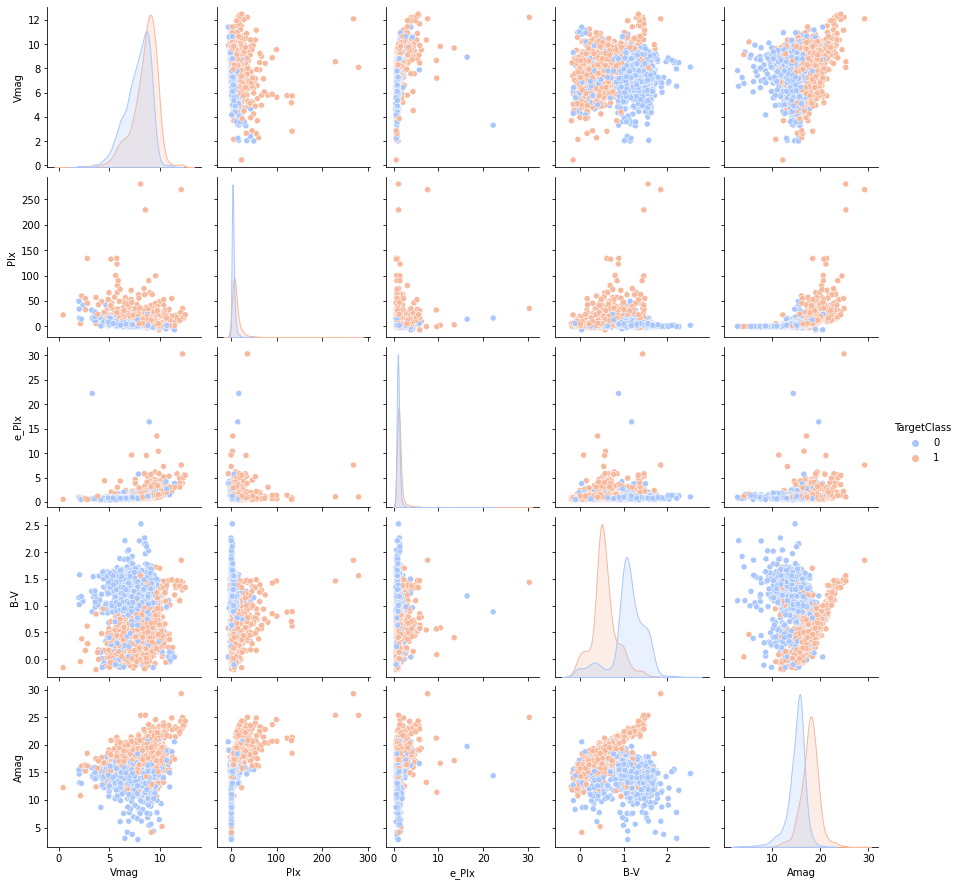

In [9]:
sns.pairplot(stars, hue='TargetClass', palette='coolwarm')

Looking at nearly every single one of these plots, you can see that there is a very clear division between specral types. Let's take a looker at this especially well-divided plot - Vmag vs Amag

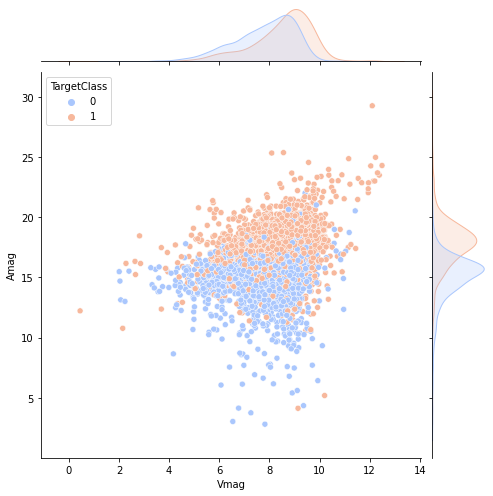

In [10]:
sns.jointplot(x='Vmag', y='Amag', data=stars, hue='TargetClass', palette='coolwarm', height=7, ratio = 6)

Looking at this plot, we can see that you could draw a basic curve separating the two groups and there would only be a few stars left out of place. Essentially every other plot shows this same pattern, and for this reason, it is likely like KNN and SVM will make good predictors for this dataset.

## Standardizing the Data

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
scaler.fit(stars.drop('TargetClass', axis=1))

StandardScaler()

In [13]:
scaled_features = scaler.transform(stars.drop('TargetClass', axis=1))
stars_scaled = pd.DataFrame(scaled_features, columns=stars.columns[:-1])

In [14]:
stars_scaled.head()

,Vmag,Plx,e_Plx,B-V,Amag
0,-1.591502,0.513641,-0.648533,1.124323,0.103371
1,0.432863,-0.444218,0.123313,-1.997250,-0.374546
2,-1.755841,-0.176655,-0.159335,0.063950,-0.805489
3,-1.046193,-0.196785,-0.474596,-1.928543,-0.454096
4,0.477683,0.489318,-0.018011,-0.556700,1.225223


## Splitting the Data

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = stars_scaled
y = stars['TargetClass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## KNN Model

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [18]:
n_max = 40
n_best = 0
accuracy_best = 0

for i in range(1, n_max):
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(X_train, y_train)
    KNN_pred = KNN.predict(X_test)
    if accuracy_score(y_test, KNN_pred) > accuracy_best:
        accuracy_best = accuracy_score(y_test, KNN_pred)
        n_best = i
print('The best value of n neighbors is {} with an accuracy of {}%'.format(n_best, (accuracy_best*100)))

The best value of n neighbors is 18 with an accuracy of 89.02104300091491%


In [19]:
KNN = KNeighborsClassifier(n_neighbors=n_best)
KNN.fit(X_train, y_train)
KNN_pred = KNN.predict(X_test)

In [20]:
print(confusion_matrix(y_test, KNN_pred))
print('\n')
print(classification_report(y_test, KNN_pred))

[[486  54]
 [ 66 487]]


              precision    recall  f1-score   support

           0       0.88      0.90      0.89       540
           1       0.90      0.88      0.89       553

    accuracy                           0.89      1093
   macro avg       0.89      0.89      0.89      1093
weighted avg       0.89      0.89      0.89      1093



In [21]:
print('Final KNN accuracy is {}%'.format(accuracy_score(y_test, KNN_pred)*100))

Final KNN accuracy is 89.02104300091491%


## SVM Model

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [23]:
SVM = SVC()

In [24]:
SVM.fit(X_train, y_train)

SVC()

In [25]:
SVM_pred = SVM.predict(X_test)

In [26]:
print(confusion_matrix(y_test, SVM_pred))
print('\n')
print(classification_report(y_test, SVM_pred))

[[485  55]
 [ 66 487]]


              precision    recall  f1-score   support

           0       0.88      0.90      0.89       540
           1       0.90      0.88      0.89       553

    accuracy                           0.89      1093
   macro avg       0.89      0.89      0.89      1093
weighted avg       0.89      0.89      0.89      1093



In [27]:
print('Default SVM accuracy is {}%'.format(accuracy_score(y_test, SVM_pred)*100))

Default SVM accuracy is 88.9295516925892%


With default values, our SMV accuracy is just under 89%. We should be able to improve this by adjusting our parameters

In [28]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'kernel':['rbf', 'poly', 'sigmoid', 'linear']}

In [29]:
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

In [30]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.1s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, kernel=sigmoid ...........................................
[CV] ............................ C=0.1, kernel=sigmoid, total=   0.0s
[CV] 

[CV] ................................ C=100, kernel=rbf, total=   0.1s
[CV] C=100, kernel=rbf ...............................................
[CV] ................................ C=100, kernel=rbf, total=   0.1s
[CV] C=100, kernel=rbf ...............................................
[CV] ................................ C=100, kernel=rbf, total=   0.1s
[CV] C=100, kernel=poly ..............................................
[CV] ............................... C=100, kernel=poly, total=   0.3s
[CV] C=100, kernel=poly ..............................................
[CV] ............................... C=100, kernel=poly, total=   0.3s
[CV] C=100, kernel=poly ..............................................
[CV] ............................... C=100, kernel=poly, total=   0.2s
[CV] C=100, kernel=poly ..............................................
[CV] ............................... C=100, kernel=poly, total=   0.3s
[CV] C=100, kernel=poly ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   34.0s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=2)

In [31]:
grid.best_params_

{'C': 10, 'kernel': 'rbf'}

From the default values, this will only change C from 1 to 10. It looks like we were already quite close to begin with, but we should still be able to improve the accuracy slightly

In [32]:
grid_pred = grid.predict(X_test)

In [33]:
print(confusion_matrix(y_test, grid_pred))
print('\n')
print(classification_report(y_test, grid_pred))

[[484  56]
 [ 62 491]]


              precision    recall  f1-score   support

           0       0.89      0.90      0.89       540
           1       0.90      0.89      0.89       553

    accuracy                           0.89      1093
   macro avg       0.89      0.89      0.89      1093
weighted avg       0.89      0.89      0.89      1093



In [34]:
print('final SVM accuracy is {}%'.format(accuracy_score(y_test, grid_pred)*100))

final SVM accuracy is 89.20402561756633%


## Logistic Regression Model

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
LogReg = LogisticRegression(max_iter=10000)

In [37]:
LogReg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [38]:
Log_pred = LogReg.predict(X_test)

In [39]:
print(confusion_matrix(y_test, Log_pred))
print('\n')
print(classification_report(y_test, Log_pred))

[[480  60]
 [ 62 491]]


              precision    recall  f1-score   support

           0       0.89      0.89      0.89       540
           1       0.89      0.89      0.89       553

    accuracy                           0.89      1093
   macro avg       0.89      0.89      0.89      1093
weighted avg       0.89      0.89      0.89      1093



In [40]:
print('Logistic Regression accuracy is {}%'.format(accuracy_score(y_test, Log_pred)*100))

Logistic Regression accuracy is 88.8380603842635%


## Conclusion

In [41]:
print('KNN accuracy is {}%'.format(accuracy_score(y_test, KNN_pred)*100))
print('SVM accuracy is {}%'.format(accuracy_score(y_test, grid_pred)*100))
print('Logistic Regression accuracy is {}%'.format(accuracy_score(y_test, Log_pred)*100))

KNN accuracy is 89.02104300091491%
SVM accuracy is 89.20402561756633%
Logistic Regression accuracy is 88.8380603842635%


SVM is the most accurate at 89.2%, though they were all remarkably consistant, with the lowest being just 0.4% lower at 88.8% accurate.